<a href="https://colab.research.google.com/github/itberrios/algotrading/blob/main/descriptive_analytics/descriptive_appl_15min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Data Explorer**

In this notebook we will aquire stock data and explore it.

## Install necessary Libraries

In [ ]:
!pip install pandas_ta

In [ ]:
!pip install alpha_vantage

## Base Library Import

In [7]:
import os
import numpy as np
import pandas as pd
import pandas_ta as ta
import alpha_vantage
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

In [8]:
API_KEY = 'K1GZTUTQ65SVGLNU'

## Get Daily Stock Data from Home Depot

In [88]:
import csv
import requests

base_url = 'https://www.alphavantage.co/query?'
function = 'TIME_SERIES_INTRADAY_EXTENDED'
# outputsize = 'full' # full returns all data, compact returns a the most recent 100
tslice = 'year2month1'
interval =  '15min'
symbol = 'AAPL'
adjusted = 'true'


CSV_URL = f'{base_url}function={function}&symbol={symbol}&slice={tslice}&interval={interval}&apikey={API_KEY}'

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')

In [89]:
df = pd.DataFrame(list(cr))
df.columns = df.iloc[0, :]
df.drop(axis=0, index=0, inplace=True)
df.index = df.time
df.drop(axis=1, columns=['time'], inplace=True)
df = df.astype(np.float64).sort_index()

In [90]:
df

,open,high,low,close,volume
time,,,,,
2021-08-24 04:15:00,149.165349,149.374181,149.165349,149.244904,20858.0
2021-08-24 04:30:00,149.244904,149.314515,149.244904,149.294626,5553.0
2021-08-24 04:45:00,149.304570,149.304570,149.145460,149.165349,18707.0
2021-08-24 05:00:00,149.165349,149.215071,149.125572,149.205127,4132.0
2021-08-24 05:15:00,149.205127,149.284681,149.165349,149.284681,10583.0
...,...,...,...,...,...
2021-09-22 19:00:00,145.237328,145.306939,145.187607,145.296994,27544.0
2021-09-22 19:15:00,145.197551,145.336772,145.197551,145.287050,9001.0
2021-09-22 19:30:00,145.306939,145.336772,145.296994,145.316883,9186.0


Save to a .csv for later usage

In [ ]:
df.to_csv('aapl_15min_20210824_2021_0922.csv')

## Checkpoint

In [ ]:
df = pd.read_csv('aapl_15min_20210824_2021_0922.csv', index_col=0)
df

We can plot a candle stick chart if we want to, see [this](https://www.statology.org/matplotlib-python-candlestick-chart/)

Now we can close inspect and analye the training data. The first thing we will do is plot Simple Moving Averages (SMA) which that the unweighted mean of the previous M points

In [91]:
# compute simple moving averages
close_sma_10 = df['close'].rolling(10, min_periods=1).mean()# .name('close SMA 10')
close_sma_30 = df['close'].rolling(30, min_periods=1).mean()

# rename series
close_sma_10.name = 'close SMA 10'
close_sma_30.name = 'close SMA 30'

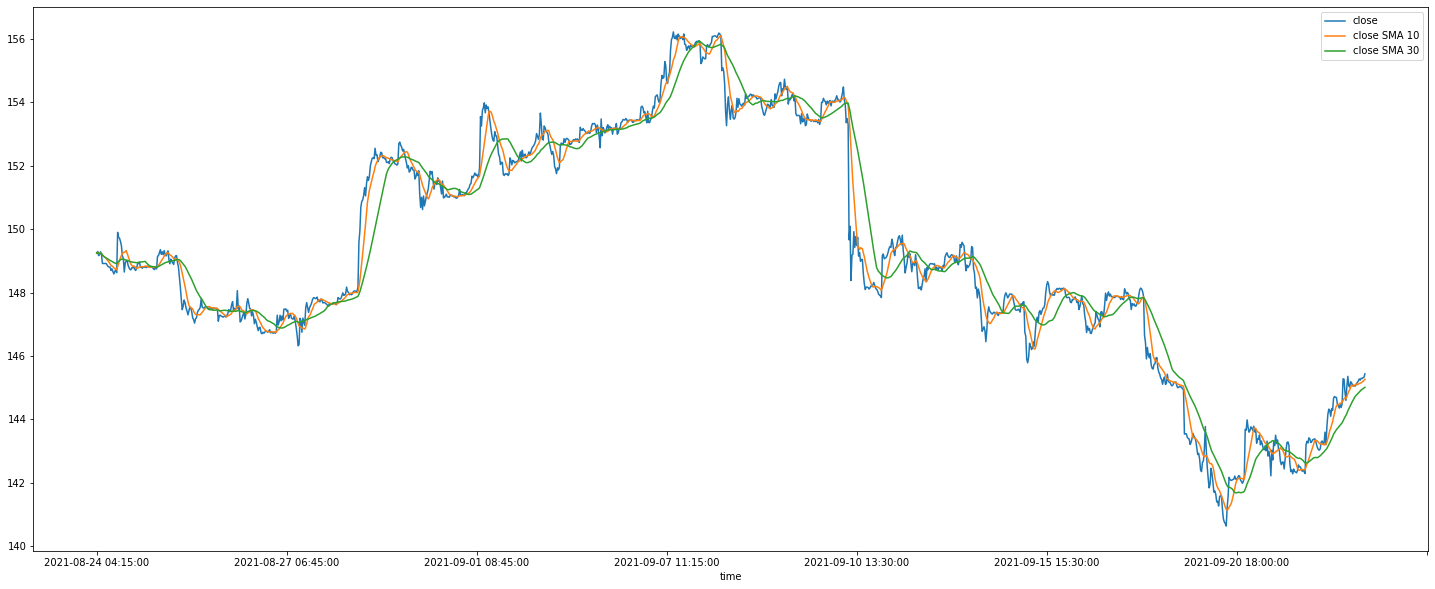

In [92]:
df['close'].plot(figsize=(25, 10))
close_sma_10.plot(figsize=(25, 10))
close_sma_30.plot(figsize=(25, 10))
plt.legend();

Now we will compute the Exponential Moving Average (EMA), the EMA gives more weight to more recent points and is useful to identify trends and filter out noise. Thee EMA formula has a smoothing factor $\alpha \in [0, 1]$ which allows for more or less smoothing. The smaller the $\alpha$, the more smoothing we get.

In [95]:
# compute Exponentially Weighted Mean
close_ema_01 = df['close'].ewm(alpha=0.1).mean()
close_ema_03 = df['close'].ewm(alpha=0.3).mean()
close_ema_05 = df['close'].ewm(alpha=0.5).mean()

# rename series
close_ema_01.name = 'close EMA 0.1'
close_ema_03.name = 'close EMA 0.3'
close_ema_05.name = 'close EMA 0.5'

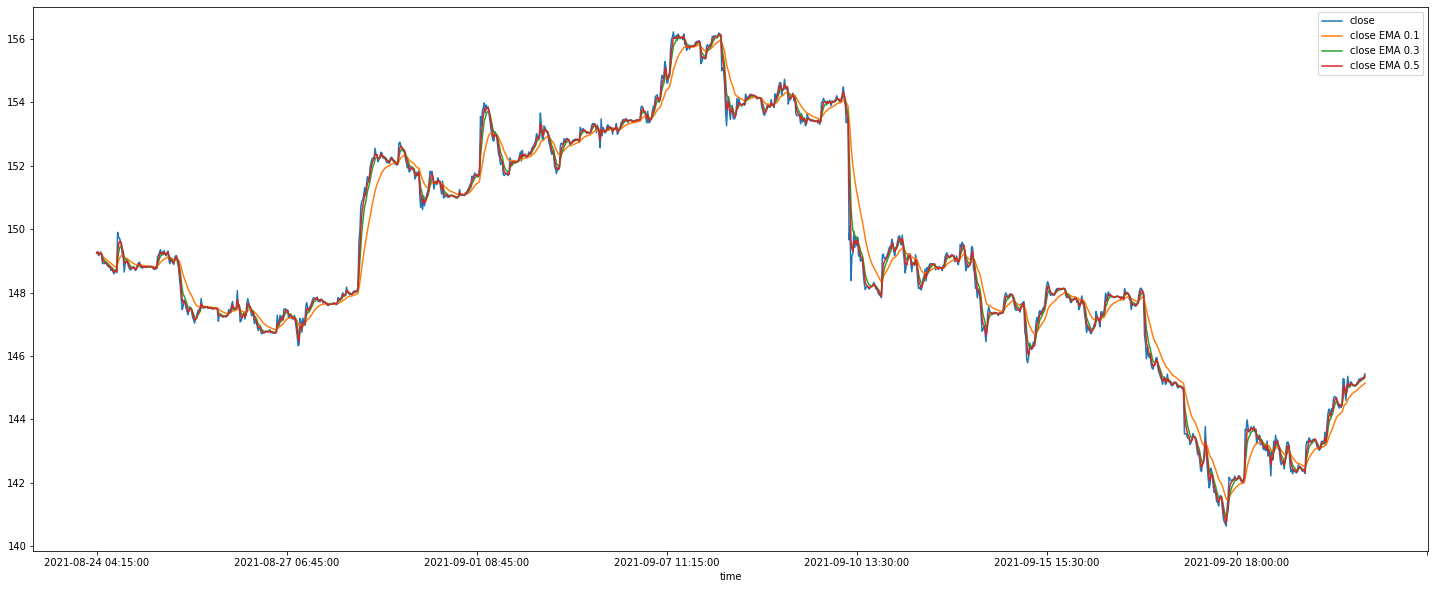

In [96]:
df['close'].plot(figsize=(25, 10))
close_ema_01.plot(figsize=(25, 10))
close_ema_03.plot(figsize=(25, 10))
close_ema_05.plot(figsize=(25, 10))
plt.legend();

We can see that chooseing an $\alpha$ value of $0.5$ gives a fairly good representation of the Time Series with a decent amount of noise removed

Now we will plot the Autocorrelation function ([ACF](https://en.wikipedia.org/wiki/Autocorrelation)]. The Autocorrelation is the correlation of a signal with a delayed copy of itself. The ACF can reveal which lags have significant correlations.

See [this](https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/) for autocorrelation VS partial autocorrelation

In [97]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

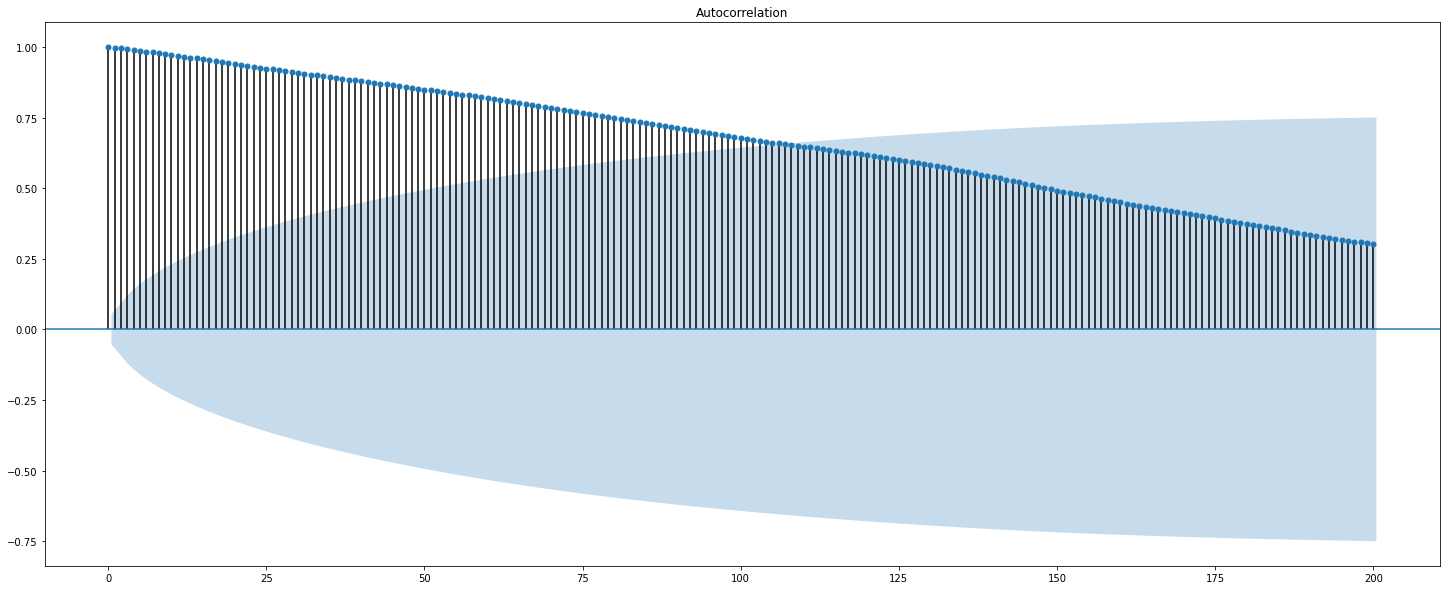

In [98]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_acf(df['close'], lags=200, ax=ax);

From this Autocorrelation plot, we can determine which lags have significant correlations. The lags above the shaded region are statistically significant, the default $\alpha$ value for significance is 0.05. We may be able to suggest that there are trends in the Time Series, since the autocorrelation lags taper off slowly as they increase in value. We can also confirm from the Autocorrelation plot that the stock data is highly non stationary.

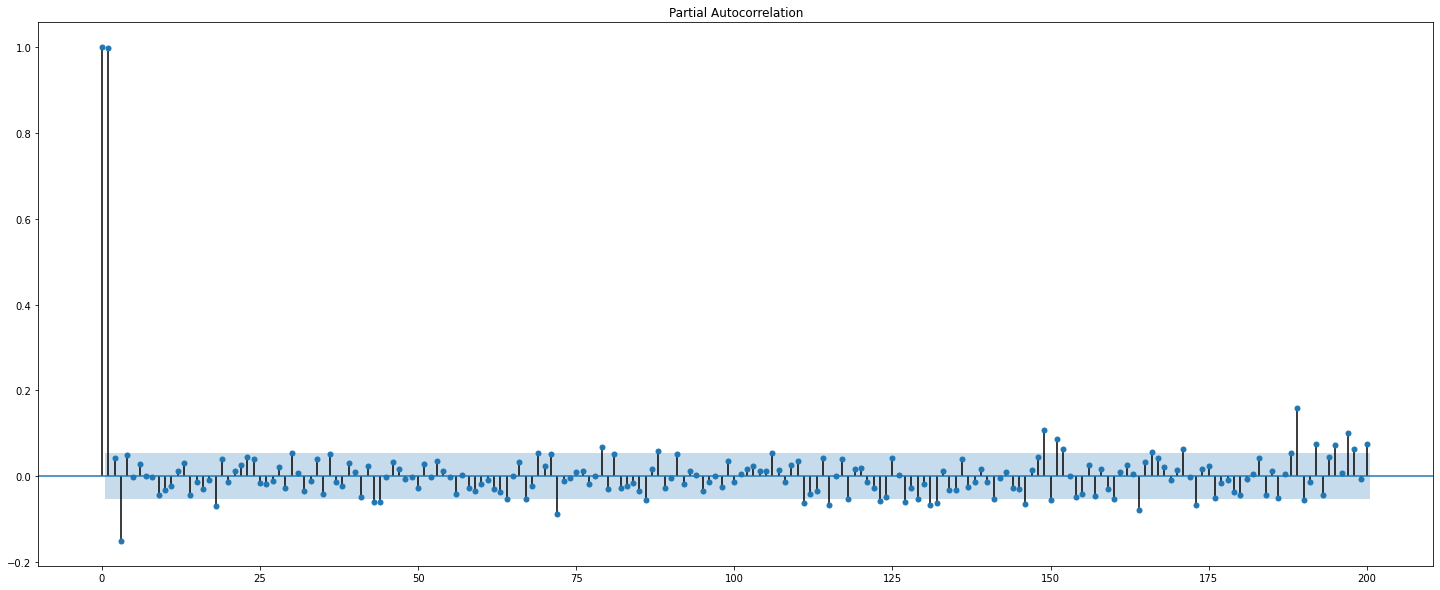

In [99]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_pacf(df['close'], lags=200, ax=ax);

For differences between Autocorrelation and Partial Autocoorelation see [this](https://emel333.medium.com/interpreting-autocorrelation-partial-autocorrelation-plots-for-time-series-analysis-23f87b102c64). The main difference is that Partial Autocorrelation shows the relationship between an observation and previous observations with the relationships of intervening observations removed. The two large postive autocorrelations suggests that we could use a 2nd order Auto Regressize (AR) model to model this stock data.

In [102]:
close_diff.describe()

count    1335.000000
mean       -0.002853
std         0.249656
min        -3.638938
25%        -0.089002
50%         0.000000
75%         0.074533
max         1.601041
Name: close, dtype: float64

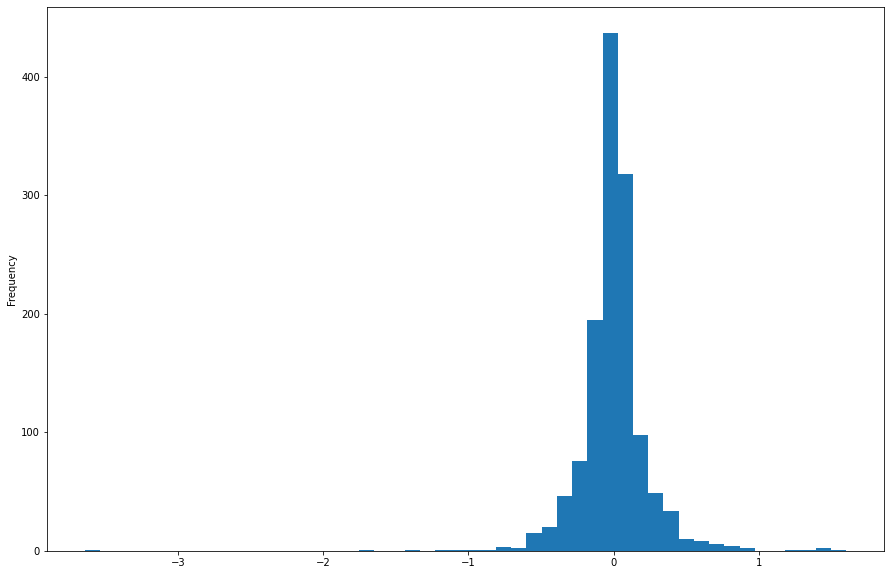

In [103]:
close_diff.plot(kind='hist', bins=50, figsize=(15, 10));

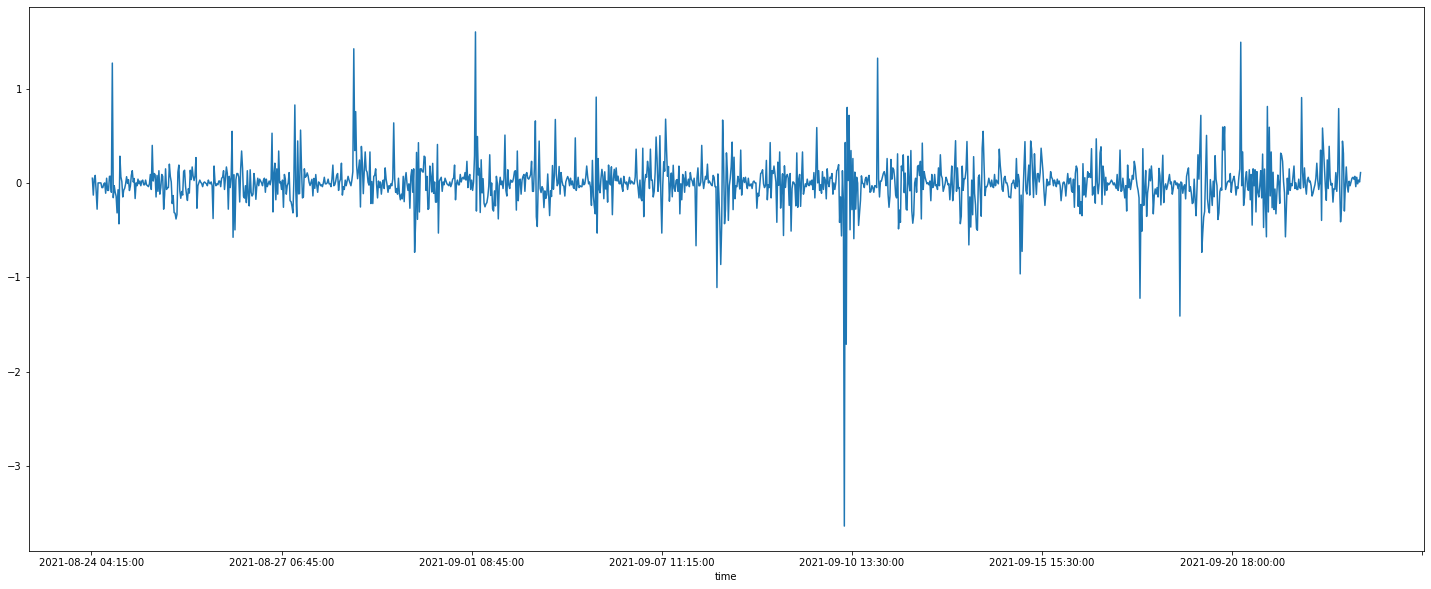

In [101]:
close_diff = df['close'].diff().sort_index() # ensure that the dates are ordered
close_diff.names = 'close diff'
close_diff.plot(figsize=(25, 10));

In [104]:
# set NaNs equal to 0
close_diff[close_diff.isna()] = 0

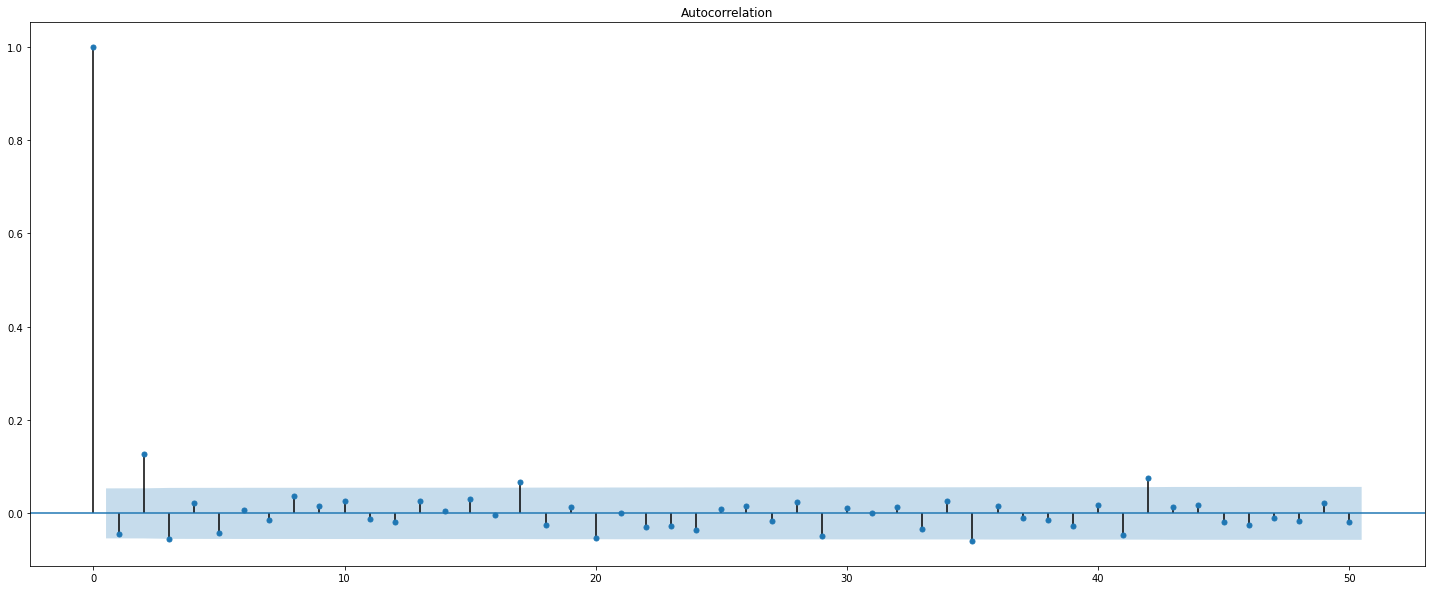

In [108]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_acf(close_diff, lags=50, ax=ax);

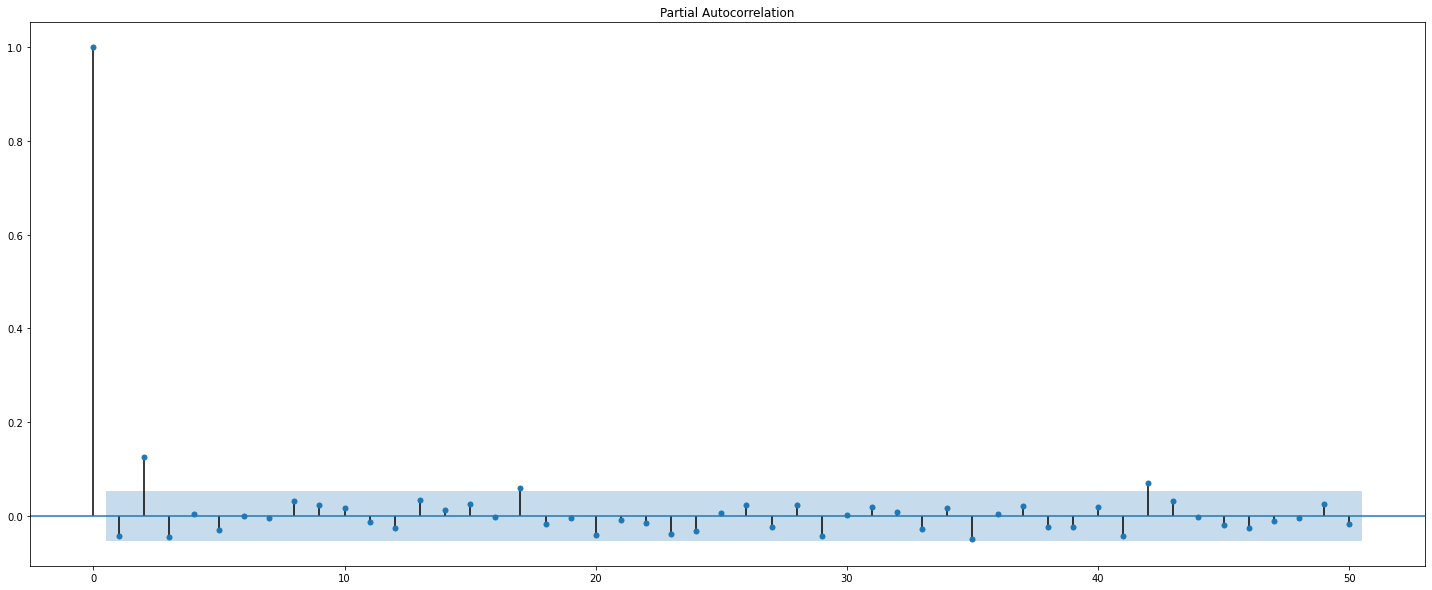

In [109]:
_, ax = plt.subplots(1, 1, figsize=(25, 10))
plot_pacf(close_diff, lags=50, ax=ax);

## **Perform Time Series Clustering**

First we will need to identify where the major prices increases and decrease occur.

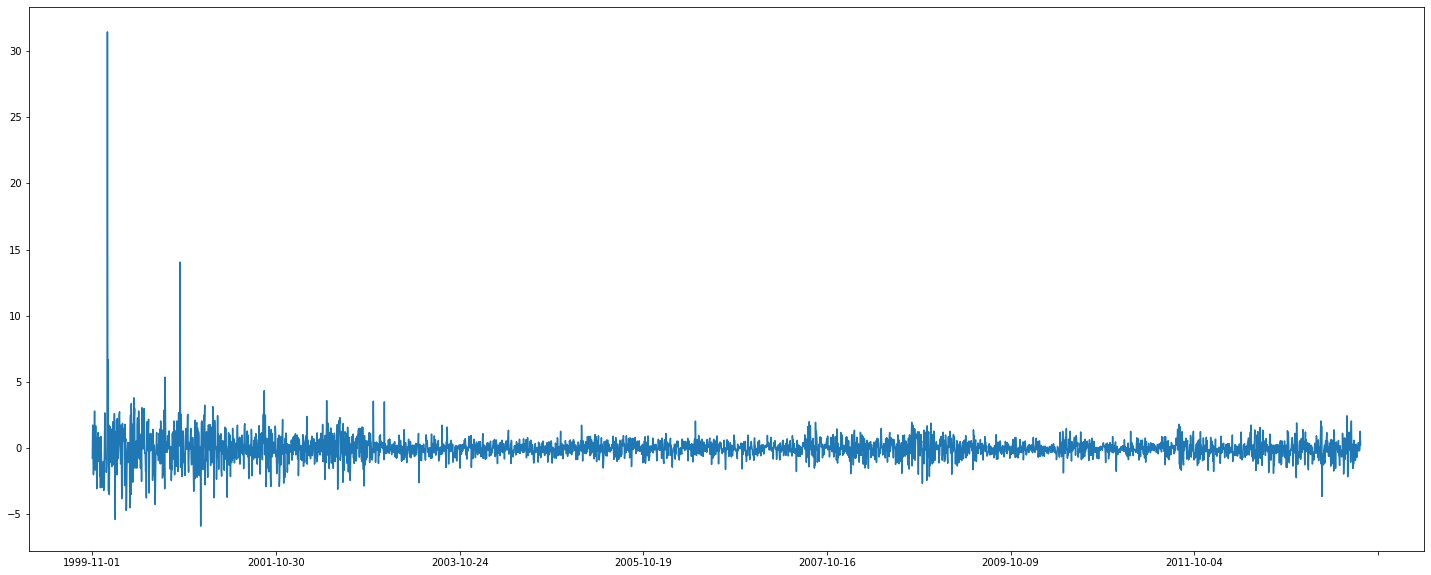

In [128]:
price_increase_locs = np.where(close_diff > 0.5)[0]
price_decrease_locs = np.where(close_diff < -0.5)[0]

Now let's get each chop price increase into it's own Time Series of $n$ values. Then we can try to cluster these Time Series and see if there are any consistencies in the data leading up to the price increase. Note that some of the price increases happen on near simultaneous days, especially if there is a large run up. We will need to figure out how to account for this. We will also cluster the Time Series Leading up to price decreases to see if there are any major differences.

In [141]:
n = 15 # number of value per trime series
price_increase_locs = price_increase_locs[price_increase_locs > n]
price_decrease_locs = price_decrease_locs[price_decrease_locs > n]

# get chopped Time Series for price increases
ts_up_list = []
for loc in price_increase_locs:
    ts_vals = df['close'].to_numpy()[loc-n:loc+1]
    ts_up_list.append(ts_vals)

# get chopped Time Series for price decreases
ts_down_list = []
for loc in price_decrease_locs:
    ts_vals = df['close'].to_numpy()[loc-n:loc+1]
    ts_down_list.append(ts_vals)

In [142]:
ts_up_array = np.array(ts_up_list)
ts_down_array = np.array(ts_down_list)

Now let's cluster the chopped Time Series. We will use [tslearn](https://tslearn.readthedocs.io/en/stable/index.html) to perform K-means clustering on the Time Series. We will also Standardize the Time Series to have 0 mean and a Standard Deviation of 1. We will choose not to detrend or de seasonalize the chopped Time Series, since we want the clusters to capture this information.

In [ ]:
!pip install tslearn

In [152]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

ts_kmeans_up = TimeSeriesKMeans(n_clusters=4, metric="softdtw",
                                max_iter=10, random_state=42)
ts_kmeans_down = TimeSeriesKMeans(n_clusters=4, metric="softdtw",
                                max_iter=10, random_state=42)

ts_up_array_transformed = TimeSeriesScalerMeanVariance(mu=0., 
                                                       std=1.).fit_transform(ts_up_array) \
                                                              .squeeze()
ts_down_array_transformed = TimeSeriesScalerMeanVariance(mu=0., 
                                                       std=1.).fit_transform(ts_down_array) \
                                                              .squeeze()                                                              

In [153]:
ts_up_cluster_locs = ts_kmeans_up.fit_predict(ts_up_array_transformed)

In [154]:
ts_down_cluster_locs = ts_kmeans_down.fit_predict(ts_down_array_transformed)

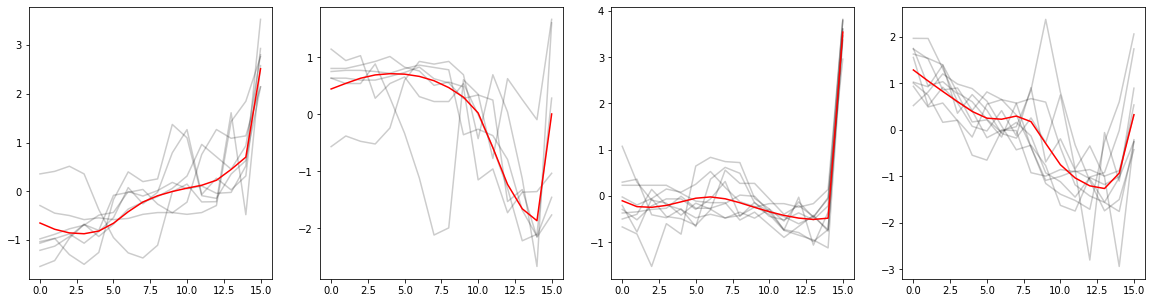

In [159]:
# display price increase clusters
fig = plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    for ts_vals in ts_up_array_transformed[ts_up_cluster_locs == i]:
        plt.plot(ts_vals.ravel(), 'k-', alpha=.2)

    plt.plot(ts_kmeans_up.cluster_centers_[i].ravel(), 'r-')

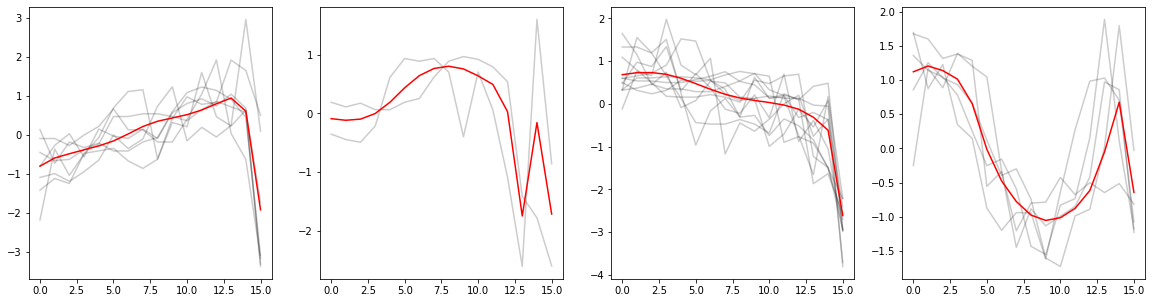

In [160]:
# display price decrease clusters
fig = plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(1, 4, 1 + i)
    for ts_vals in ts_down_array_transformed[ts_down_cluster_locs == i]:
        plt.plot(ts_vals.ravel(), 'k-', alpha=.2)

    plt.plot(ts_kmeans_down.cluster_centers_[i].ravel(), 'r-')

There doesn't seem to be anything special about the clusters obtained from this analysis of daily data. It's possible that more meaningful clusters can be found when observing the data through a different time scale such as an hourly interval or 15minute interval.

In [ ]:
!pip install stumpy

In [163]:
import stumpy

m = 15
mp = stumpy.stump(df['close'].sort_index(), m=m)

From stumpy [github](https://github.com/TDAmeritrade/stumpy/blob/main/stumpy/stump.py):

```
out : numpy.ndarray
        The first column consists of the matrix profile, the second column
        consists of the matrix profile indices, the third column consists of
        the left matrix profile indices, and the fourth column consists of
        the right matrix profile indices.
```
      

In [164]:
motif_idx = np.argsort(mp[:, 0])[0]
nearest_neighbor_idx = mp[motif_idx, 1]

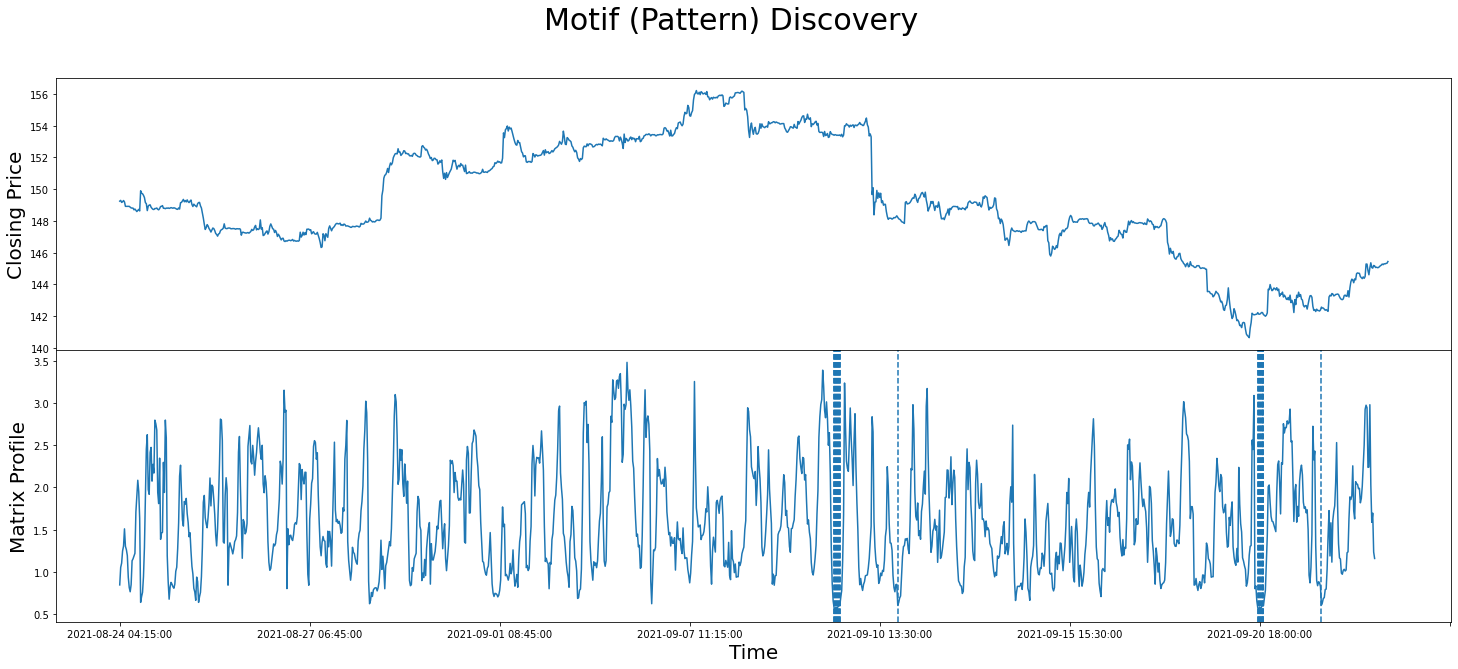

In [166]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(25, 10))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

# plot closing price
df['close'].sort_index().plot(ax=axs[0])
axs[0].set_ylabel('Closing Price', fontsize='20')

# plot Matrix Profile
axs[1].plot(mp[:, 0])

# indicate Motif locaitons
for i in range(15):
    # get motifs
    motif_idx = np.argsort(mp[:, 0])[i]
    nearest_neighbor_idx = mp[motif_idx, 1]

    rect = Rectangle((motif_idx, 0), m, 100, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 100, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")

plt.show()

## Plot top 15 motifs

First filter out motifs that are close together in time. Since motifs that are within 5-10 lags will have very similar patterns, but are not useful for our analysis.

In [231]:
# get motifs to plots

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []
motif_indexes_to_plot = []

# threshold for similar motifs spacd in time 
thresh = 15

i = 0
while i < 100:
    # get motifs
    motif_idx = np.argsort(mp[:, 0])[i]
    nearest_neighbor_idx = mp[motif_idx, 1]

    if i == 0:
        motif_indexes_to_plot.append(motif_idx)

        # store motif index
        motif_indexes.append(motif_idx)

        # increment i
        i += 1

        continue
    
    if (np.min(np.abs(motif_idx - np.array(motif_indexes))) > thresh):
        motif_indexes_to_plot.append(motif_idx)

    # store motif index
    motif_indexes.append(motif_idx)
    
    # increment i
    i += 1

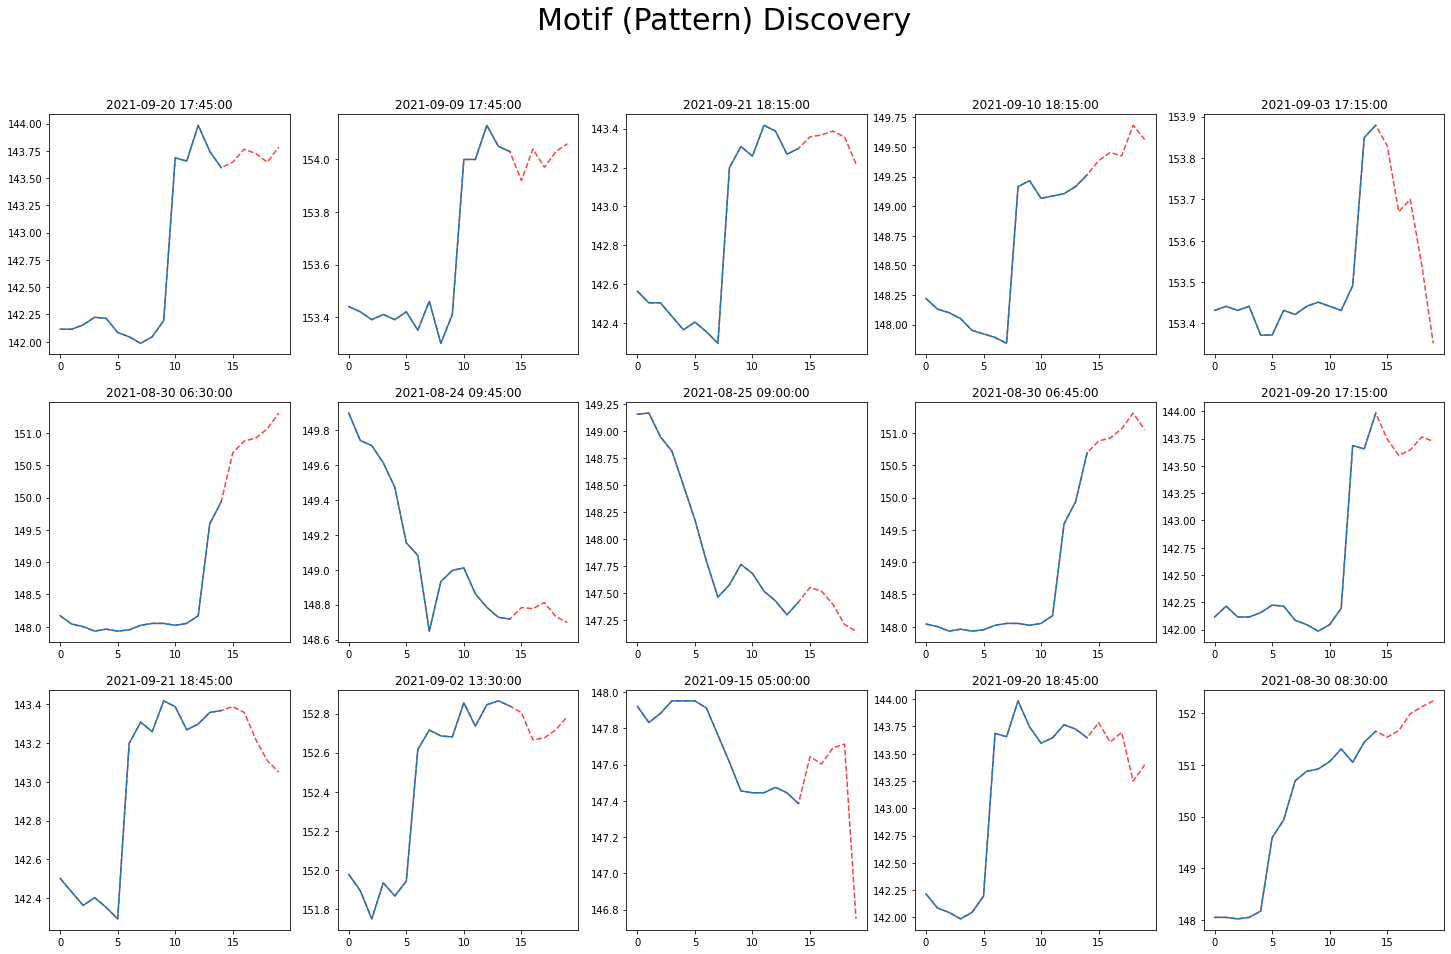

In [232]:
# display each discovered motif

# store motif indexes to ensure that matches close in time are not plotted
motif_indexes = []

# threshold for similar motifs spacd in time 
thresh = 15

fig = plt.figure(figsize=(25, 15))
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

i = 0
for i in range(15):
    plt.subplot(3, 5, 1 + i)

    # get motifs
    # motif_idx = np.argsort(mp[:, 0])[i]
    motif_idx = motif_indexes_to_plot[i]
    nearest_neighbor_idx = mp[motif_idx, 1]


    # plot motif index
    motif = df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + m]
    motif_ext = df['close'].iloc[nearest_neighbor_idx:nearest_neighbor_idx + m + 5]

    plt.plot(motif_ext.to_numpy(), 'r--', alpha=0.75)
    plt.plot(motif.to_numpy())
    
    plt.title(df['close'].index[nearest_neighbor_idx])


In [198]:
np.min(np.abs(1199 - np.array([753])))

446

From the Matrix Profiling, the Blue indicates the matched Motifs and the Red is the next 10 days after the matched motif. Aside from rises and falls the patterns don't appear to be significant.

## **Perform Fourier Analysis**

In [233]:
# set NaNs equal to 0
close_diff[close_diff.isna()] = 0

In [234]:
sp = np.fft.fft(close_diff)
theta = np.arctan(sp.imag/sp.real)
numValues = len(close_diff)
numValuesHalf = numValues/2

amp = np.abs(sp)/np.sqrt(numValues)
freq = np.fft.fftfreq(sp.size, d=1)

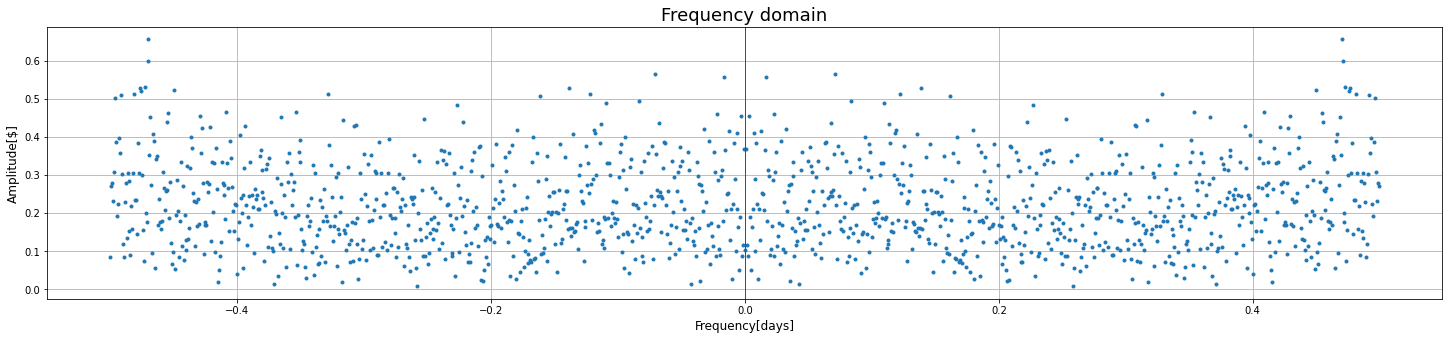

In [235]:
plt.figure(figsize=(25,5))
plt.plot(freq, amp ,'.')
plt.axvline(x=0, ymin=0, ymax=1, linewidth=1, color='r')

plt.ylabel('Amplitude[$]', fontsize=12)
plt.xlabel('Frequency[days]', fontsize=12)
plt.title('Frequency domain', fontsize=18)
plt.grid()

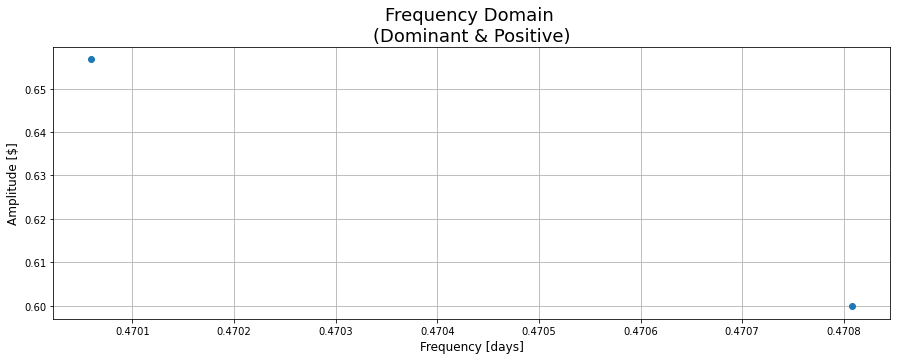

In [236]:
meanAmp = amp.mean()
stdAmp = amp.std()
dominantAmpCheck = amp > (3*stdAmp + meanAmp) 
positiveFreqCheck = freq > 0
dominantAmp = amp[dominantAmpCheck & positiveFreqCheck]
dominantFreq = freq[dominantAmpCheck & positiveFreqCheck]
dominantTheta = theta[dominantAmpCheck & positiveFreqCheck]

plt.figure(figsize=(15,5))
plt.plot(dominantFreq, dominantAmp, 'o')
plt.ylabel('Amplitude [$]', fontsize=12)
plt.xlabel('Frequency [days]', fontsize=12)
plt.title('Frequency Domain \n(Dominant & Positive)', fontsize=18)
plt.grid()

In [237]:
dominantAmp, dominantFreq

(array([0.65676372, 0.59978314]), array([0.47005988, 0.47080838]))

## **Perform Wavelet Analysis**